# Missing values

Different methods for dealing with missing values in your dataset.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

## Dataset

House prices in Melbourne.

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


melbourne_data = pd.read_csv('../../data/melb_data.csv')
melbourne_data = melbourne_data.drop(columns=['Unnamed: 0'])

y = melbourne_data.Price
X = melbourne_data.drop(columns=['Price'])

# drop categorical features for now
X = X.select_dtypes(exclude=['object'])

In [3]:
X.shape

(18396, 12)

In [4]:
X.head()

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
0,2,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,-37.7996,144.9984,4019.0
1,2,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0
2,3,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,4019.0
3,3,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,-37.7969,144.9969,4019.0
4,4,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,4019.0


## Visuale representation of missingness

https://github.com/ResidentMario/missingno

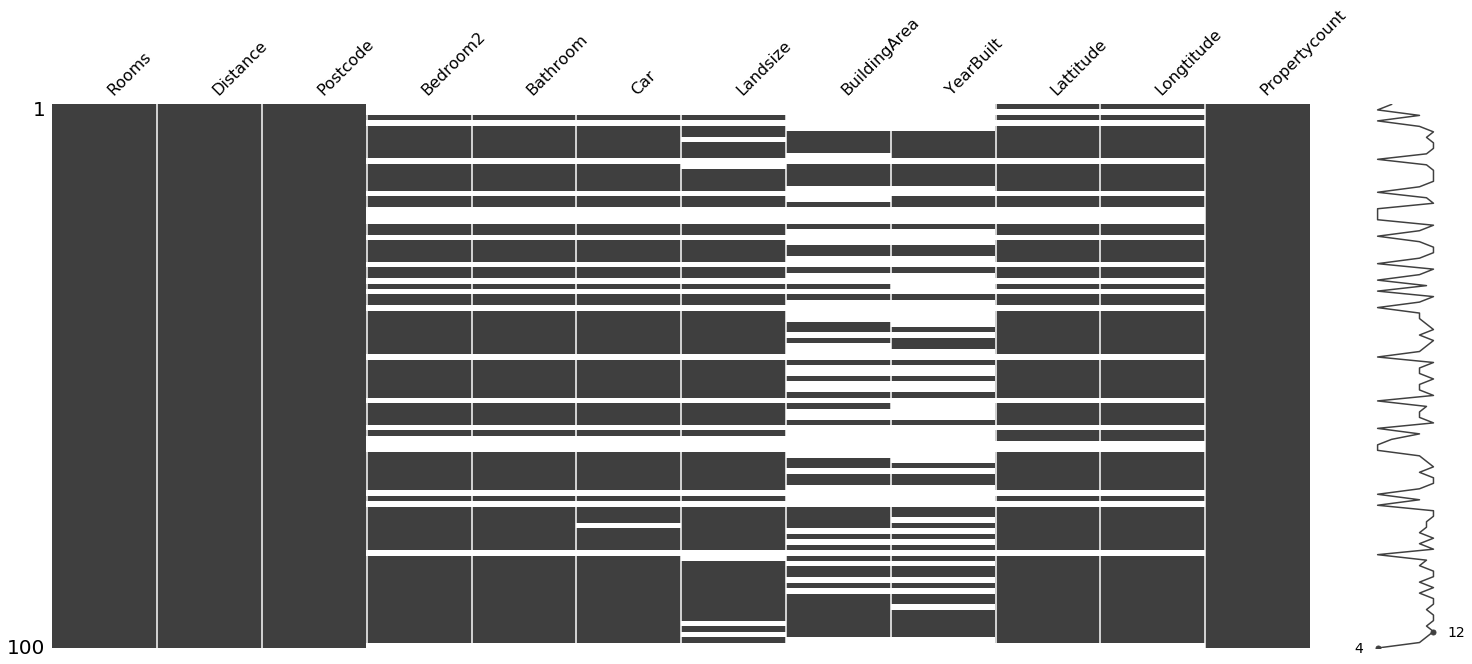

In [5]:
import missingno as msno


msno.matrix(X.sample(100))

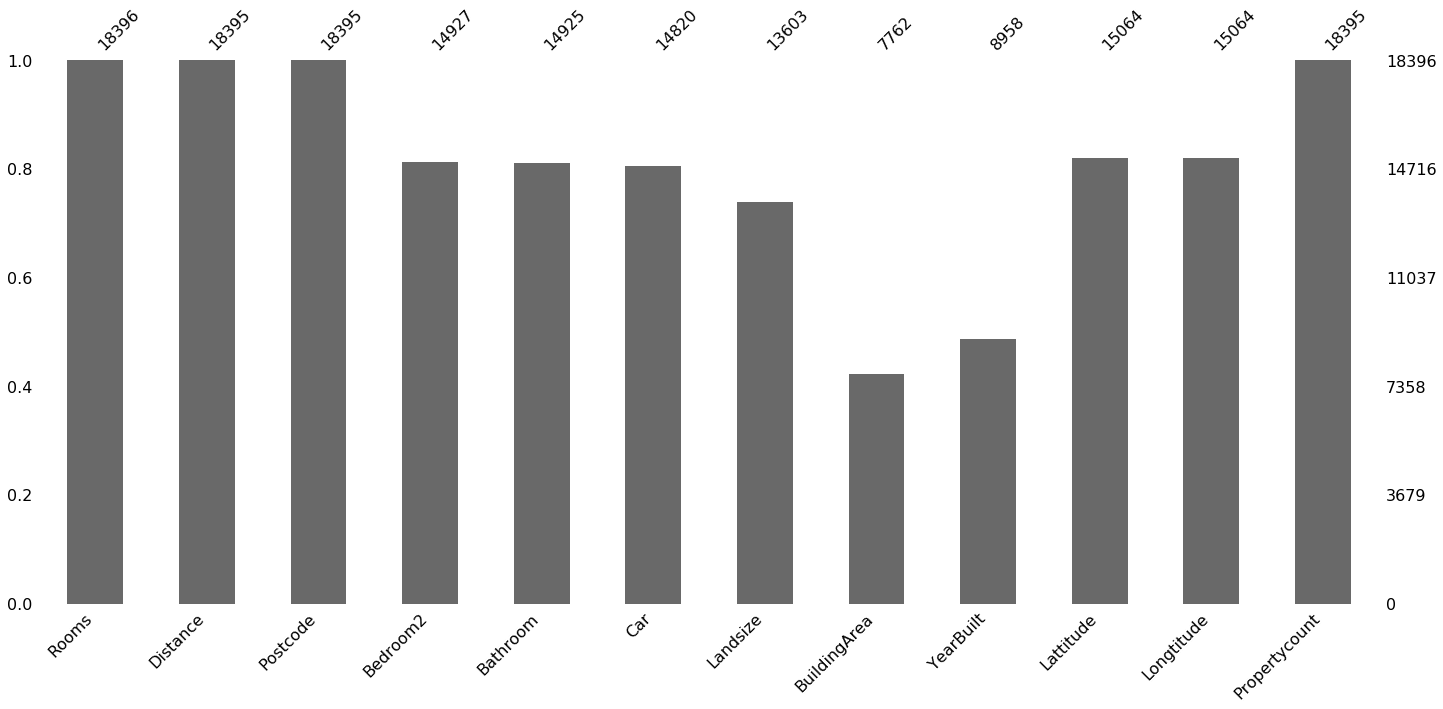

In [6]:
msno.bar(X)

## Split off training and testing data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X.as_matrix(), y, random_state=42)

## Drop columns with missing values

Simplest possible approach.

In [8]:
with_missing = np.any(np.isnan(X_train), axis=0)

X_train_drop = X_train[:, ~with_missing]
X_test_drop = X_test[:, ~with_missing]

In [9]:
# only one column left!
X_train_drop.shape

(13797, 1)

In [10]:
rf = RandomForestRegressor()

scores = cross_val_score(rf, X_train_drop, y_train,
                         scoring='neg_mean_absolute_error',
                         cv=10)
-1 * np.mean(scores), np.std(scores)

(381103.80459376186, 9824.928165083093)

## Impute missing values

There are different strategies for how to impute the missing values.
* If “mean”, then replace missing values using the mean along the axis.
* If “median”, then replace missing values using the median along the axis.
* If “most_frequent”, then replace missing using the most frequent value along the axis.

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer

imputer = Imputer()
imputer.fit_transform(X)[:4]

array([[ 2.00000000e+00,  2.50000000e+00,  3.06700000e+03,
         2.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         2.02000000e+02,  1.51220219e+02,  1.96588000e+03,
        -3.77996000e+01,  1.44998400e+02,  4.01900000e+03],
       [ 2.00000000e+00,  2.50000000e+00,  3.06700000e+03,
         2.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         1.56000000e+02,  7.90000000e+01,  1.90000000e+03,
        -3.78079000e+01,  1.44993400e+02,  4.01900000e+03],
       [ 3.00000000e+00,  2.50000000e+00,  3.06700000e+03,
         3.00000000e+00,  2.00000000e+00,  0.00000000e+00,
         1.34000000e+02,  1.50000000e+02,  1.90000000e+03,
        -3.78093000e+01,  1.44994400e+02,  4.01900000e+03],
       [ 3.00000000e+00,  2.50000000e+00,  3.06700000e+03,
         3.00000000e+00,  2.00000000e+00,  1.00000000e+00,
         9.40000000e+01,  1.51220219e+02,  1.96588000e+03,
        -3.77969000e+01,  1.44996900e+02,  4.01900000e+03]])

In [12]:
# default strategy uses the mean
imputed = make_pipeline(Imputer(), RandomForestRegressor())

scores = cross_val_score(imputed, X_train, y_train,
                         scoring='neg_mean_absolute_error',
                         cv=10)
-1 * np.mean(scores), np.std(scores)

(199256.7116756251, 6649.635065566727)

In [13]:
imputed = make_pipeline(Imputer(strategy='most_frequent'), RandomForestRegressor())

scores = cross_val_score(imputed, X_train, y_train,
                         scoring='neg_mean_absolute_error',
                         cv=10)
-1 * np.mean(scores), np.std(scores)

(201245.50699168333, 7316.8573719691)

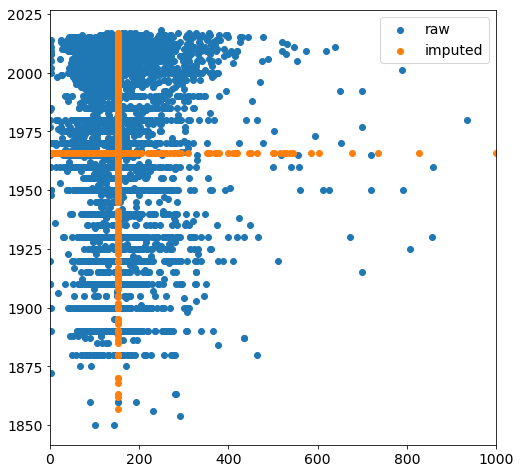

In [14]:
X_train_ = Imputer().fit_transform(X_train, y_train)

# find indices with one missing value
missing_idx = np.any(np.isnan(X_train[:,7:9]), axis=1)

plt.scatter(X_train[~missing_idx, 7], X_train[~missing_idx, 8], label='raw')
plt.scatter(X_train_[missing_idx, 7], X_train_[missing_idx, 8], label='imputed')
plt.xlim([0, 1000])
plt.legend(loc='best');

## Missingness means something

You should add extra features that signal that there was a missing value that got imputed.

This gives the model a way to know that the value in that column is an imputed value and should (maybe) get less weight.

In [15]:
# which columns have any missing values?
with_missing

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [16]:
X_train[:5, with_missing]

array([[ 9.7000000e+00,  3.1030000e+03,  2.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  1.6110000e+03,            nan,            nan,
        -3.7809200e+01,  1.4510160e+02,  5.6820000e+03],
       [ 1.2000000e+01,  3.0730000e+03,  2.0000000e+00,  1.0000000e+00,
         2.0000000e+00,  5.7600000e+02,            nan,            nan,
        -3.7695730e+01,  1.4501689e+02,  2.1650000e+04],
       [ 7.4000000e+00,  3.1440000e+03,  3.0000000e+00,  2.0000000e+00,
         2.0000000e+00,  1.9200000e+02,  1.9100000e+02,  2.0100000e+03,
        -3.7865400e+01,  1.4502970e+02,  4.6750000e+03],
       [ 6.3000000e+00,  3.1430000e+03,  1.0000000e+00,  1.0000000e+00,
         1.0000000e+00,  0.0000000e+00,            nan,            nan,
        -3.7860500e+01,  1.4501850e+02,  4.8360000e+03],
       [ 1.2000000e+01,  3.0730000e+03,  2.0000000e+00,  1.0000000e+00,
         2.0000000e+00,  6.4900000e+02,            nan,            nan,
        -3.7710860e+01,  1.4501629e+02,  2.1650000e+

In [17]:
# for first five rows, which fields in these rows are missing?
np.isnan(X_train[:5, with_missing])

array([[False, False, False, False, False, False,  True,  True, False,
        False, False],
       [False, False, False, False, False, False,  True,  True, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False,  True,  True, False,
        False, False],
       [False, False, False, False, False, False,  True,  True, False,
        False, False]])

Create a "mask" which is a set of new features which tell you for each sample which of the values were added by imputation.

In [18]:
missing_mask = np.isnan(X_train[:, with_missing])
X_train_marked = np.hstack([X_train, missing_mask])

In [19]:
# 11 columns have missing values, so we now have 12+11 columns
X_train.shape, X_train_marked.shape

((13797, 12), (13797, 23))

In [20]:
print(X_train[:1, :])
print("-----------------")
print(X_train_marked[:1, :])

[[ 2.000000e+00  9.700000e+00  3.103000e+03  2.000000e+00  0.000000e+00
   0.000000e+00  1.611000e+03           nan           nan -3.780920e+01
   1.451016e+02  5.682000e+03]]
-----------------
[[ 2.000000e+00  9.700000e+00  3.103000e+03  2.000000e+00  0.000000e+00
   0.000000e+00  1.611000e+03           nan           nan -3.780920e+01
   1.451016e+02  5.682000e+03  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00]]


In [21]:
imputed = make_pipeline(Imputer(), RandomForestRegressor())

scores = cross_val_score(imputed, X_train_marked, y_train,
                         scoring='neg_mean_absolute_error',
                         cv=10)
-1 * np.mean(scores), np.std(scores)

(198840.22241708156, 8421.443221262485)

In this case doesn't lead to much of an improvement. Spread of scores has reduced though, might mean that things are more stable now.

## Model based imputation

Instead of filling in values based on the mean or median we can use a regression model to fill in values based on similar entries that are complete.

In [22]:
from fancyimpute import KNN, SoftImpute

# Use 3 nearest rows which have a feature to fill in each row's missing features
X_train_knn = KNN(k=3).complete(X_train)

Using TensorFlow backend.


Imputing row 1/13797 with 2 missing, elapsed time: 44.063
Imputing row 101/13797 with 2 missing, elapsed time: 44.112
Imputing row 201/13797 with 2 missing, elapsed time: 44.154
Imputing row 301/13797 with 1 missing, elapsed time: 44.191
Imputing row 401/13797 with 2 missing, elapsed time: 44.236
Imputing row 501/13797 with 2 missing, elapsed time: 44.282
Imputing row 601/13797 with 0 missing, elapsed time: 44.334
Imputing row 701/13797 with 1 missing, elapsed time: 44.375
Imputing row 801/13797 with 8 missing, elapsed time: 44.420
Imputing row 901/13797 with 0 missing, elapsed time: 44.454
Imputing row 1001/13797 with 2 missing, elapsed time: 44.499
Imputing row 1101/13797 with 3 missing, elapsed time: 44.537
Imputing row 1201/13797 with 0 missing, elapsed time: 44.607
Imputing row 1301/13797 with 1 missing, elapsed time: 44.664
Imputing row 1401/13797 with 0 missing, elapsed time: 44.707
Imputing row 1501/13797 with 8 missing, elapsed time: 44.750
Imputing row 1601/13797 with 8 missi

Imputing row 13501/13797 with 8 missing, elapsed time: 50.023
Imputing row 13601/13797 with 3 missing, elapsed time: 50.069
Imputing row 13701/13797 with 0 missing, elapsed time: 50.125


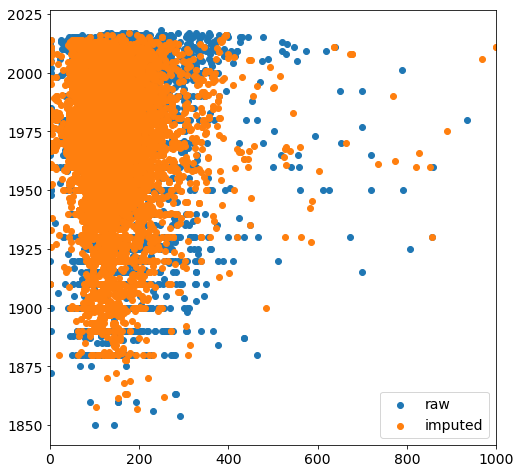

In [23]:
# find indices with one missing value
missing_idx = np.any(np.isnan(X_train[:,7:9]), axis=1)

plt.scatter(X_train[~missing_idx, 7], X_train[~missing_idx, 8], label='raw')
plt.scatter(X_train_knn[missing_idx, 7], X_train_knn[missing_idx, 8], label='imputed')
plt.xlim([0, 1000])
plt.legend(loc='best');

In [24]:
scores = cross_val_score(RandomForestRegressor(), X_train_knn, y_train,
                         scoring='neg_mean_absolute_error',
                         cv=10)
-1 * np.mean(scores), np.std(scores)

(204915.1048976785, 9666.315530916794)

In [25]:
from fancyimpute import MICE

X_train_mice = MICE(verbose=0).complete(X_train)

In [26]:
scores = cross_val_score(RandomForestRegressor(), X_train_mice, y_train,
                         scoring='neg_mean_absolute_error',
                         cv=10)
-1 * np.mean(scores), np.std(scores)

(208043.10507515148, 5242.79613108314)

Neither method seems to improve things for this dataset.

## Imputation using Regression

In [27]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=6)

# need to somehow initialise all the missing values to something
X_train_rf = Imputer().fit_transform(X_train)

for i in range(10):
    last = X_train_rf.copy()
    for feature in range(X_train.shape[1]):
        inds_not_f = np.arange(X_train.shape[1])
        inds_not_f = inds_not_f[inds_not_f != feature]
        f_missing = np.isnan(X_train[:, feature])

        # skip this if there are no missing values for this feature
        if not np.any(f_missing):
            continue

        rf.fit(X_train_rf[~f_missing][:, inds_not_f],
               X_train[~f_missing, feature])

        X_train_rf[f_missing, feature] = rf.predict(
            X_train_rf[f_missing][:, inds_not_f])

    if (np.linalg.norm(last - X_train_rf)) < .5:
        break
        

In [28]:
scores = cross_val_score(RandomForestRegressor(), X_train_rf, y_train,
                         scoring='neg_mean_absolute_error',
                         cv=10)
-1 * np.mean(scores), np.std(scores)

(200528.99025056796, 7014.969465109931)